<a href="https://it-omscholing.nl/locaties/hogeschool-rotterdam/">
<div>
<a><img src='../../pics/banner.PNG'/></a>
</div>
<div>
<a href=''><img src='../../pics/miw.PNG'/></a>
</div>
</a>

# Practicum Convolution Neural Nets (CNN) Deel 1

**Doel: Toepassen Convolutional Neural Networks**

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torch.nn.functional as FF
import torchvision.transforms.functional as F
import torchvision.transforms as T
import wandb
from os import listdir, path
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from tqdm import tqdm





In [2]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

<h3>Globale variabelen</h3>

In [ ]:
forestDirectory = '../../pics/2750/Forest'
industrialDirectory = '../../pics/2750/Industrial'

In [ ]:
# # to show a single image in a dataset with its label shaped as either (3, 64, 64) or (1, 64, 64) tensor.

# def ShowDatasetImage(dataset, index=0):
#     # if index is random, pick a random index number
#     if index == 'random':
#         index = random.randint(0, len(dataset) - 1)

#     # Access the image and label using indexing
#     image, label = dataset[index]
#     image, label = 1,1

#     # Convert the image tensor to a NumPy array and transpose the dimensions
#     np_image = np.transpose(image.numpy(), (1, 2, 0))
#     np_image = image.squeeze().numpy().transpose((1, 2, 0))

#     # Normalize the pixel values to the range [0, 1]
#     np_image = np_image / 255.0

#     # Display the image using matplotlib
#     plt.imshow(np_image)
#     # Show the label and the shape of the tensor image
#     image_shape = image.shape
#     plt.title(f"Label: {label} - {image_shape}")
#     plt.axis('off')
#     plt.show()
#     print(image)

    # to show an image from the dataloader with its label

def ShowDatasetImage(dataset, index=0):
    # if index is random, pick a random index number
    if index == 'random':
        index = random.randint(0, len(dataset) - 1)


    # Set the savefig.bbox parameter to 'tight'
    plt.rcParams["savefig.bbox"] = 'tight'

    # Retrieve the first tensor and its corresponding label
    image = dataset[0][0]
    label = dataset[1][0]
  

    # Convert the image tensor to a NumPy array and transpose the dimensions
    np_image = image.permute(1, 2, 0).numpy()

        # Display the image using matplotlib
    plt.imshow(np_image)
    # Show the label and the shape of the tensor image
    image_shape = image.shape
    plt.title(f"Label: {label} - {image_shape}")
    plt.axis('off')
    plt.show()
    # print(image)



In [ ]:
# show a single image from the dataloader

def ShowDataloaderImage(dataloader):
    # Get the batch of images and labels from the dataloader
    images, labels = next(iter(dataloader))

    # Access the first image and label
    image, label = images[0], labels[0]

    # Convert the image tensor to a NumPy array and transpose the dimensions
    np_image = np.transpose(image.numpy(), (1, 2, 0))

    # Normalize the pixel values to the range [0, 1]
    np_image = np_image / 255.0

    # Display the image using matplotlib
    plt.imshow(np_image)
    # Show the label and the shape of the tensor image
    image_shape = image.shape
    plt.title(f"Label: {label} - {image_shape}")
    plt.axis('off')
    plt.show()
    print(image)






    

In [6]:
# to show an image from the dataloader with its label
def show_batch(train_d,test_d,val_d):
    # Get a batch of data from the DataLoader
    data_train = next(iter(train_d))
    data_test = next(iter(test_d))
    data_val = next(iter(val_d))

    # Set the savefig.bbox parameter to 'tight'
    plt.rcParams["savefig.bbox"] = 'tight'

    # Retrieve the first tensor and its corresponding label
    image_train = data_train[0][0]
    image_test = data_test[0][0]
    image_val = data_val[0][0]
    label_train = data_train[1][0]
    label_test = data_test[1][0]
    label_val = data_val[1][0]
  

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 3)


    # Convert the image tensor to a NumPy array and transpose the dimensions
    np_image_train = image_train.permute(1, 2, 0).numpy()
    np_image_test = image_test.permute(1, 2, 0).numpy()
    np_image_val = image_val.permute(1, 2, 0).numpy()
    

        # Display the original image in the first subplot
    axes[0].imshow(np_image_train)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[0].set_title(f'{label_train}, {image_train.shape}')

    # Display the pooled image in the second subplot
    axes[1].imshow(np_image_test)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[1].set_title(f'{label_test}, {image_test.shape}')

    # Display the pooled image in the third subplot
    axes[2].imshow(np_image_val)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[2].set_title(f'{label_val}, {image_val.shape}')

    # Adjust spacing between subplots to prevent overlap
    fig.tight_layout()

    # Show the plot
    plt.show()

### Context

<p>
Dit practicum bestaat uit twee onderdelen
<ol>
    <li>Het toepassen van een convolutie en pooling filter</li>
    <li><b>Het bouwen en trainen van een eenvoudig convolutional neural net dat een industrieterrein van een bos kan onderscheiden.</b></li>
</ol>    
Voor beide oefeningen gebruiken we de EuroSAT_RGB dataset
</p>

<img src='../../pics/eurosat_cnn.png' length=65% width=65%>

<h3>Data Collection</h3>
<p>
We gebruiken Images uit de <a href="https://github.com/phelber/EuroSAT">EuroSat dataset</a> die gemaakt zijn met de Sentinel-2 sateliet. Elke image is een 64x64 pixels foto van Europees aardoppervlak op een hoogte van 10 meter. De images zijn te categoriseren in Highway, Industrial, Pasture, PermanentCrop, Residential, River en SeaLake.
</p>
<img src=../../pics/eurosat_overview_small.jpg length=40% width=40%>
<p>
Download <a href="http://madm.dfki.de/files/sentinel/EuroSAT.zip">EuroSAT.zip</a> en kopieer daaruit de directory 2750 naar opdrachten/practica/pics.      
<strong>Voeg het pad naar de directory 2750 toe aan .gitignore zodat je de plaatjes niet naar je remote git repository pusht</strong>
</p>    

## Opdrachten

### Opdracht 3: pooling uitvoeren

Met PyTorch Functional kunnen we ook een pooling filter toepassen.

In [ ]:
# a. Bekijk de pooling opties en kies de juiste avg-variant
#    - https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html


# b. Pas pooling toe op de afbeelding 'Industrial_1.jpg':
#    - Zet de afbeelding om naar een tensor
LOCATION = industrialDirectory
IMPORTPATH = f'{LOCATION}/Industrial_1.jpg'
industrial = torchvision.io.read_image(IMPORTPATH, mode=ImageReadMode.GRAY).to(torch.float32)
print(f'the image dtype = {industrial.dtype}, its shape = {industrial.shape}')


#    - Kies een 3x3 kernel en een stride van 1
industrialPooled = nn.AvgPool2d(kernel_size=3, stride=1)(industrial)

#    - Plot de afbeelding en de ge-poolde afbeelding    

# Set the savefig.bbox parameter to 'tight'
plt.rcParams["savefig.bbox"] = 'tight'


# Remove single-dimensional entries from the shape of the tensors
industrial = np.squeeze(industrial)
industrialPooled = np.squeeze(industrialPooled)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Display the original image in the first subplot
axes[0].imshow(industrial)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0].set_title('Original Image')

# Display the pooled image in the second subplot
axes[1].imshow(industrialPooled)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1].set_title('Pooled Image')

# Adjust spacing between subplots to prevent overlap
fig.tight_layout()

# Show the plot
plt.show()  

# c. Herhaal de bovenstaande stappen voor een willekeure Forest Image

In [ ]:
# a. Bekijk de pooling opties en kies de juiste avg-variant
#    - https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html


# b. Pas pooling toe op de afbeelding 'Industrial_1.jpg':
#    - Zet de afbeelding om naar een tensor
LOCATION = forestDirectory
IMPORTPATH = f'{LOCATION}/{random.choice(listdir(forestDirectory))}'
industrial = torchvision.io.read_image(IMPORTPATH, mode=ImageReadMode.GRAY).to(torch.float32)
print(f'the image dtype = {industrial.dtype}, its shape = {industrial.shape}')


#    - Kies een 3x3 kernel en een stride van 1
industrialPooled = nn.AvgPool2d(kernel_size=3, stride=1)(industrial)

#    - Plot de afbeelding en de ge-poolde afbeelding    

# Set the savefig.bbox parameter to 'tight'
plt.rcParams["savefig.bbox"] = 'tight'


# Remove single-dimensional entries from the shape of the tensors
industrial = np.squeeze(industrial)
industrialPooled = np.squeeze(industrialPooled)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Display the original image in the first subplot
axes[0].imshow(industrial)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0].set_title('Original Image')

# Display the pooled image in the second subplot
axes[1].imshow(industrialPooled)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1].set_title('Pooled Image')

# Adjust spacing between subplots to prevent overlap
fig.tight_layout()

# Show the plot



# c. Herhaal de bovenstaande stappen voor een willekeure Forest Image

### Reflectie

Komt de visuele uitkomst overeen met je verwachtingen?

In [ ]:
# door de kernel te vergroten wordt de afbeelding steeds grofkorreliger


# b. Pas pooling toe op de afbeelding 'Industrial_1.jpg':
#    - Zet de afbeelding om naar een tensor
LOCATION = forestDirectory
IMPORTPATH = f'{LOCATION}/{random.choice(listdir(forestDirectory))}'
industrial = torchvision.io.read_image(IMPORTPATH, mode=ImageReadMode.GRAY).to(torch.float32)
print(f'the image dtype = {industrial.dtype}, its shape = {industrial.shape}')

kernel0 = 3
kernel1 = 4
kernel2 = 5

#    - Kies een 3x3 kernel en een stride van 1
industrialPooled = nn.AvgPool2d(kernel_size=(kernel0), stride=1)(industrial)

#    - Kies een 3x3 kernel en een stride van 1
industrialPooled1 = nn.AvgPool2d(kernel_size=(kernel1), stride=1)(industrial)

#    - Kies een 3x3 kernel en een stride van 1
industrialPooled2 = nn.AvgPool2d(kernel_size=(kernel2), stride=1)(industrial)

#    - Plot de afbeelding en de ge-poolde afbeelding    

# Set the savefig.bbox parameter to 'tight'
plt.rcParams["savefig.bbox"] = 'tight'


# Remove single-dimensional entries from the shape of the tensors
img0 = np.squeeze(industrial)
img1 = np.squeeze(industrialPooled)
img2 = np.squeeze(industrialPooled1)
img3 = np.squeeze(industrialPooled2)

# Create a figure with two subplots
fig, axes = plt.subplots(2, 2)

# Display the original image in the first subplot
axes[0][0].imshow(img0)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0][0].set_title(f'Original {img0.shape}')

# Display the pooled image in the second subplot
axes[0][1].imshow(img1)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0][1].set_title(f'Pooled kernel {kernel0} {img1.shape}')

# Display the pooled image in the second subplot
axes[1][0].imshow(img2)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1][0].set_title(f'Pooled kernel {kernel1} {img2.shape}')

# Display the pooled image in the second subplot
axes[1][1].imshow(img3)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1][1].set_title(f'Pooled kernel {kernel2} {img3.shape}')

# Adjust spacing between subplots to prevent overlap
fig.tight_layout()

# Show the plot
plt


### Reflectie

Wat is de invloed van padding en stride op de uitkomst?

In [ ]:
# door de kernel te vergroten wordt de afbeelding steeds grofkorreliger


# b. Pas pooling toe op de afbeelding 'Industrial_1.jpg':
#    - Zet de afbeelding om naar een tensor
LOCATION = forestDirectory
IMPORTPATH = f'{LOCATION}/{random.choice(listdir(forestDirectory))}'
industrial = torchvision.io.read_image(IMPORTPATH, mode=ImageReadMode.GRAY).to(torch.float32)
print(f'the image dtype = {industrial.dtype}, its shape = {industrial.shape}')

kernel0 = 3
kernel1 = 3
kernel2 = 3

stride0 = 1
stride1 = 2
stride2 = 3


#    - Kies een 3x3 kernel en een stride van 1
industrialPooled = nn.AvgPool2d(kernel_size=(kernel0), stride=stride0)(industrial)

#    - Kies een 3x3 kernel en een stride van 2
industrialPooled1 = nn.AvgPool2d(kernel_size=(kernel1), stride=stride1)(industrial)

#    - Kies een 3x3 kernel en een stride van 3
industrialPooled2 = nn.AvgPool2d(kernel_size=(kernel2), stride=stride2)(industrial)

#    - Plot de afbeelding en de ge-poolde afbeelding    

# Set the savefig.bbox parameter to 'tight'
plt.rcParams["savefig.bbox"] = 'tight'


# Remove single-dimensional entries from the shape of the tensors
img0 = np.squeeze(industrial)
img1 = np.squeeze(industrialPooled)
img2 = np.squeeze(industrialPooled1)
img3 = np.squeeze(industrialPooled2)

# Create a figure with two subplots
fig, axes = plt.subplots(2, 2)

# Display the original image in the first subplot
axes[0][0].imshow(img0)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0][0].set_title('Original Image')

# Display the pooled image in the second subplot
axes[0][1].imshow(img1)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0][1].set_title(f'Pooled Image stride {stride0}')

# Display the pooled image in the second subplot
axes[1][0].imshow(img2)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1][0].set_title(f'Pooled Image stride {stride1}')

# Display the pooled image in the second subplot
axes[1][1].imshow(img3)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1][1].set_title(f'Pooled Image stride {stride2}')

# Adjust spacing between subplots to prevent overlap
fig.tight_layout()

# Show the plot
plt.show


In [ ]:
# when adding the padding it should be at most half the kernel size
# bij het plotten van de afbeeldingen gebeurt er iets geks, de grijswaardes in het midden van de afbeelding worden lichter afgebeeld doordat de buitenrand zo extreen donker is. 


#    - Zet de afbeelding om naar een tensor
LOCATION = forestDirectory
IMPORTPATH = f'{LOCATION}/{random.choice(listdir(forestDirectory))}'
industrial = torchvision.io.read_image(IMPORTPATH, mode=ImageReadMode.GRAY).to(torch.float32)
print(f'the image dtype = {industrial.dtype}, its shape = {industrial.shape}')

kernel0 = 3
kernel1 = 3
kernel2 = 5

stride0 = 1
stride1 = 1
stride2 = 1

padding0 = 0
padding1 = 1
padding2 = 2


#    - Kies een 3x3 kernel en een stride van 1
industrialPooled = nn.AvgPool2d(kernel_size=(kernel0), stride=stride0, padding=padding0)(industrial)

#    - Kies een 3x3 kernel en een stride van 1
industrialPooled1 = nn.AvgPool2d(kernel_size=(kernel1), stride=stride1, padding=padding1)(industrial)

#    - Kies een 3x3 kernel en een stride van 1
industrialPooled2 = nn.AvgPool2d(kernel_size=(kernel2), stride=stride2, padding=padding2)(industrial)

#    - Plot de afbeelding en de ge-poolde afbeelding    

# Set the savefig.bbox parameter to 'tight'
plt.rcParams["savefig.bbox"] = 'tight'


# Remove single-dimensional entries from the shape of the tensors
img0 = np.squeeze(industrial)
img1 = np.squeeze(industrialPooled)
img2 = np.squeeze(industrialPooled1)
img3 = np.squeeze(industrialPooled2)

# Create a figure with two subplots
fig, axes = plt.subplots(2, 2)
print(img0[32][32])
print()
print(img1[32][32])
# Display the original image in the first subplot
axes[0][0].imshow(img0)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0][0].set_title('Original Image')

# Display the pooled image in the second subplot
axes[0][1].imshow(img1)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0][1].set_title(f'Pooled Image padding {padding0}')

# Display the pooled image in the second subplot
axes[1][0].imshow(img2)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1][0].set_title(f'Pooled Image adding {padding1}')

# Display the pooled image in the second subplot
axes[1][1].imshow(img3)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1][1].set_title(f'Pooled Image adding {padding2}')

# Adjust spacing between subplots to prevent overlap
fig.tight_layout()

# Show the plot
plt

print(img0.mean())
print(img1.mean())
print(img2.mean())
print(img3.mean())


### Opdracht 4: convolutie en pooling combineren

Een convolutional neural net combineert afwisselend convolutie en pooling in de eerste lagen.

We kunnen nu het effect van deze combinatie onderzoeken:

- Convolutie
- Pooling

In [ ]:
LOCATION = industrialDirectory
IMPORTPATH = f'{LOCATION}/Industrial_2.jpg'
industrial1 = torchvision.io.read_image(IMPORTPATH, mode=ImageReadMode.GRAY).to(torch.float32)
print(f'the industrial dtype = {industrial.dtype}, its shape = {industrial.shape}')

IMPORTPATH = f'{forestDirectory}/Forest_1.jpg'
forest1 = torchvision.io.read_image(IMPORTPATH, mode=ImageReadMode.GRAY).to(torch.float32)
print(f'the forest dtype = {forest1.dtype}, its shape = {forest1.shape}')

In [ ]:

#    - Plot de afbeelding en de ge-poolde afbeelding    
def showImages(image0,image1,image2,image3,image4,image5,label0='Original',label1='Convolved',label2='Pooled',label3='Original',label4='Convolved',label5='Pooled'):
    # Set the savefig.bbox parameter to 'tight'
    plt.rcParams["savefig.bbox"] = 'tight'


    # Remove single-dimensional entries from the shape of the tensors
    img0 = np.squeeze(image0.detach().numpy())
    img1 = np.squeeze(image1.detach().numpy())
    img2 = np.squeeze(image2.detach().numpy())
    img3 = np.squeeze(image3.detach().numpy())
    img4 = np.squeeze(image4.detach().numpy())
    img5 = np.squeeze(image5.detach().numpy())

    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 3)

    # Display the original image in the first subplot
    axes[0][0].imshow(img0)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[0][0].set_title(f'{label0}, {img0.shape}')

    # Display the pooled image in the second subplot
    axes[0][1].imshow(img1)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[0][1].set_title(f'{label1}, {img1.shape}')

    # Display the pooled image in the third subplot
    axes[0][2].imshow(img2)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[0][2].set_title(f'{label2}, {img2.shape}')

    # Display the original image in the first subplot
    axes[1][0].imshow(img3)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[1][0].set_title(f'{label3}, {img3.shape}')

    # Display the pooled image in the second subplot
    axes[1][1].imshow(img4)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[1][1].set_title(f'{label4}, {img4.shape}')

    # Display the pooled image in the third subplot
    axes[1][2].imshow(img5)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[1][2].set_title(f'{label5}, {img5.shape}')

    # Adjust spacing between subplots to prevent overlap
    fig.tight_layout()

    # Show the plot
    return plt.show() 


In [ ]:
# Sobel operator For Ix(x,y)
sobel_x = torch.tensor([[-1,-2,-1],
                        [0,0,0],
                        [1,2,1]], dtype=torch.float32)
# sobel_x = torch.tensor([[0,1,2],
#                         [-1,0,1],
#                         [-2,-1,0]], dtype=torch.float32)

sobel_x_kernel = sobel_x.unsqueeze(0).unsqueeze(0)
print(f'the sobel_x_kernel dtype = {sobel_x_kernel.dtype}, its shape = {sobel_x_kernel.shape}')

# a. Bedenk en maak zelf een 2d convolution filter
convulutionFilter = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=0, bias=False)
convulutionFilter.weight.data = sobel_x_kernel

# b. Bedenk en maak zelf een 2d pooling filter
poolingFilter = nn.MaxPool2d(kernel_size=3, stride=1, padding=0)

# c. Pas nu de convolutie toe op 'Industrial_1.jpg'
industrial2 = convulutionFilter(industrial1)

# d. Pas vervolgens een pooling toe op de uitkomst van c.
industrial3 = poolingFilter(industrial2)

# e. Doe hetzelfde voor de afbeelding 'Forrest_1.jpg'
forest2 = convulutionFilter(forest1)
forest3 = poolingFilter(forest2)

# plot all images next to each other
showImages(industrial1,industrial2,industrial3,forest1,forest2,forest3)

### Reflectie

- Verschilt de uitkomst veel van de combinatie veel met convolutie en pooling?
- En zijn de afbeeldingen 'Industrial_1.jpg' en 'Forrest_1.jpg' beter te onderscheiden?

In [ ]:
# Extra: bereid de combinatie uit met nog een extra convolutie en pooling laag
industrial4 = convulutionFilter(industrial3)
industrial5 = poolingFilter(industrial4)

forest4 = convulutionFilter(forest3)
forest5 = poolingFilter(forest4)


# plot all images next to each other
showImages(industrial3,industrial4,industrial5,forest3,forest4,forest5)

In [ ]:
# Extra: bereid de combinatie uit met nog een extra convolutie en pooling laag
industrial6 = convulutionFilter(industrial5)
industrial7 = poolingFilter(industrial6)

forest6 = convulutionFilter(forest5)
forest7 = poolingFilter(forest6)


# plot all images next to each other
showImages(industrial5,industrial6,industrial7,forest5,forest6,forest7)

### Reflectie

Heeft een extra laag veel invloed op de onderscheidbaarheid van de afbeeldingen?

I have repeated the convulution/ pooling two additional times, eventually the immage gets verry blurry. switching the stride from 1 to 2 schrinks it tremendously. 
also makes it uninteligable for my human brain.

### Opdracht 5: dataset prepareren

Om het neurale netwerk te trainen moeten we de dataset opsplitsen in labels (Y, de categoriën) en input afbeeldingen (X).

In [ ]:
# # a. Denk nog eens terug aan hoe we kruisjes van rondjes van elkaar konden onderscheiden

# #    - Hoe representeerden we de labels?  # [0,1] en [1,0]
# #    - Hoe representeerden we de kruisjes en de rondjes?  # [[1,1,1],[1,0,1],[1,1,1]] en [[1,0,1],[0,1,0],[1,0,1] als basis rondje en kruisje.
# #    - Hoe combineerden we dit tot een dataset?  # als extra waarde in de array. 

# # b. Hoe kunnen we de labels 'Industrials' en 'Forrest' dus representeren? [0] is industrial and [1] is forest 

# # c. Vorm nu een dataset voor 'Industrials' en 'Forrest'

# class LandDataset(Dataset):
#     def __init__(self, directory, Label):
#         self.data = self.load_images(directory)
#         self.labels = [Label] * len(self.data)  # Assigning the same label (0) to all industrial images

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         image = self.data[index]
#         label = self.labels[index]
#         return image, label

    
#     def load_images(self, directory):
#         image_files = listdir(directory)
#         data = []
#         for file in image_files:
#             image_path = path.join(directory, file)
#             image = torchvision.io.read_image(image_path, mode=ImageReadMode.UNCHANGED).to(torch.float32)
#             data.append(image)
#         return data


# forestDataset = LandDataset(forestDirectory, [0,1])
# industrialDataset = LandDataset(industrialDirectory, [1,0])



# # d. Extra: implementeer bovenstaande via een Dataset en DataLoader class

# # Concatenate the datasets into a single dataset
# dataset = torch.utils.data.ConcatDataset([forestDataset, industrialDataset])

# ShowDatasetImage(dataset, index='random')


# #           (zie https://pytorch.org/docs/stable/data.html voor verdere details)

In [4]:
# alternative way to imort the data and a data loader

# Define the path to the root directory of your image dataset
data_dir = '../../pics/2750'

# Define the transformation to apply to each image
transform = T.Compose([
    T.ToTensor(),
    # T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization if needed as shown in blog doesnt seem to be needed
])

# Create the ImageFolder dataset
dataset = ImageFolder(data_dir, transform=transform)

# torchvision.datasets.vision.StandardTransform() look at this for more info on the transform options

In [ ]:
dataset_path = "/Users/stephandekker/workspace/Make_AI_Work_3/practica/01. Beeldherkenning/Practicum/pics/2750"
transform = T.ToTensor()
dataset = ImageFolder(dataset_path, transform=transform)



dataset.class_to_idx

In [ ]:
# # set dataset to device ...failed...

# dataset = [(data.to(device), target.to(device)) for data, target in dataset]

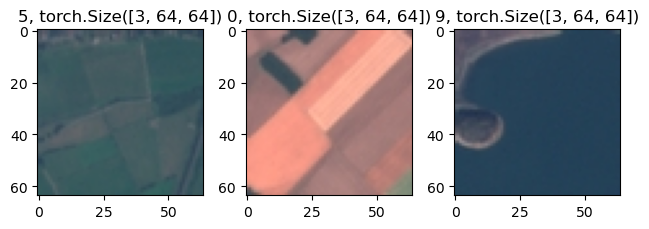

tensor([[[0.2353, 0.2353, 0.2392,  ..., 0.1882, 0.1843, 0.1843],
         [0.2392, 0.2392, 0.2392,  ..., 0.1882, 0.1843, 0.1843],
         [0.2392, 0.2353, 0.2353,  ..., 0.2000, 0.1843, 0.1922],
         ...,
         [0.2902, 0.2902, 0.2902,  ..., 0.2510, 0.2510, 0.2471],
         [0.2824, 0.2863, 0.2667,  ..., 0.2667, 0.2588, 0.2510],
         [0.2392, 0.2392, 0.2392,  ..., 0.2588, 0.2549, 0.2510]],

        [[0.3020, 0.3020, 0.2980,  ..., 0.3059, 0.3020, 0.3020],
         [0.2980, 0.2980, 0.2980,  ..., 0.3059, 0.3020, 0.3020],
         [0.2941, 0.2941, 0.2941,  ..., 0.3059, 0.2902, 0.2980],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.3098, 0.3098, 0.3059],
         [0.3373, 0.3412, 0.3176,  ..., 0.3255, 0.3176, 0.3098],
         [0.2980, 0.2980, 0.2902,  ..., 0.3176, 0.3137, 0.3098]],

        [[0.4196, 0.4196, 0.4275,  ..., 0.4157, 0.4118, 0.4118],
         [0.4196, 0.4196, 0.4275,  ..., 0.4157, 0.4118, 0.4118],
         [0.4078, 0.4157, 0.4235,  ..., 0.4118, 0.4039, 0.

In [26]:
# create the test, train and validation set and the dataloader

# setup split data 
dataset_size = len(dataset)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


# Set the seed for the generator
seed = 42
generator = torch.Generator().manual_seed(seed)

# Calculate the number of samples for each split
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)


# Define the batch size for the DataLoader
batch_size = 128

# Create the DataLoader to load the dataset in batches
train_d = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_d = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_d = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Show the 1st img in the dataset
show_batch(train_d, test_d,val_d)
print(train_dataset[0][0])


In [ ]:
# # Iterate over the DataLoader to get the batches
# for images, labels in train_d:
#     print(images[0])
#     break  # Print only the first batch

In [ ]:
# # check the number of images in the batch and a batches shape
# lengte = len(train_d.dataset) 
# print(lengte)
# for images, labels in train_d:
#     # Access the shape of the images tensor in each batch
#     image_shape = images.shape
#     print(image_shape)

#     break  # Break the loop to only print the shape of the first batch

In [ ]:
# # Set to store unique labels
# unique_labels = set()

# # Iterate over the dataloader
# for _, labels in train_d:
#     unique_labels.update(labels.tolist())

# # Print the number of unique labels
# num_unique_labels = len(unique_labels)
# print("Number of unique labels:", num_unique_labels)

### Opdracht 6: CNN ontwerpen

We kunnen een convolutional neural net opbouwen met convolutie, pooling en fully connected lagen. Hieronder definiëren we een topologie om een afbeeldingen van 32 x 32 te onderscheiden.

De topologie is gebaseerd op de blog post 'A simple CNN with Pytorch'. Dus zie het artikel voor extra details.

In [9]:
#-------------------------------------------------------

class CNN(nn.Module):
    
    #-------------------------------------------------------
    
    def __init__(self):
        
        # Because we inherit from Module base class
        super().__init__()
        
        # RGB input, 6 filters, kernel of 5 x 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # Filter is 2 x 2 with a stride of 2 (defined once, used two times)
        self.pool = nn.MaxPool2d(2, 2)
        
        # in_channels = 6 because self.conv1 output has 6 channels
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Fully connected layer matched on output of conv2 layer
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        
        # Fully connected layer
        self.fc2 = nn.Linear(120, 84)
        
        # We only have 2 labels
        self.fc3 = nn.Linear(84, 10)
        
    #-------------------------------------------------------
        
    def forward(self, x):
        
        # Convolution with relu layers
        x = self.pool(FF.relu(self.conv1(x)))
        x = self.pool(FF.relu(self.conv2(x)))
        
        # To match the output of the conv2 layer onto the first fully connected layer
        # Like reshape() but makes no copy (reuses underlaying data)
        x = x.view(-1, 16 * 13 * 13)
        
        # Fully connected layers
        x = FF.relu(self.fc1(x))
        x = FF.relu(self.fc2(x))
        
        # No activation on final layer 
        return self.fc3(x)

#-------------------------------------------------------

### Opdracht 7: CNN trainen

Het trainen van een CNN is identiek aan het trainen van een fully connected (a.k.a. dense) netwerk.

In [ ]:

# a. Ga voor jezelf na welke stappen een typisch trainingsproces bevat
 # 1. Data verzamelen
    # 2. Data voorbereiden
    # 3. Data inladen
    # 4. Model maken
    # 5. Model shape W & B opslaan tijdens het trainen
    # 5. Model trainen
    # 6. Model testen
    # 7. Model verbeteren
    # 8. Model beste model selecteren





# b. Bekijk de blog post 'A simple CNN in Python' en zet de training op

# hyperparameters
learning_rate = 0.01
epochs = 30
momentum = 0.9
total_epochs =0


# model parameters
model = CNN() # Create the model
# set model to device
model.to(device)
# set model to train mode
model.train()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

criterion = nn.CrossEntropyLoss()   # Define the loss function  
 
trainloader = train_d

epoch_loss = []

printfreq = 1000
for epoch in tqdm(range(epochs)):  # tqdm is to see the 'loading bar'
    running_loss = 0 
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # set data to device to activate mps and or cuda
        optimizer.zero_grad()
        outputs = model(inputs)  # forward pass 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        
        if i % printfreq == printfreq-1:  
            print(epoch, i+1, running_loss / printfreq)
            running_loss = 0 
        
    epoch_loss.append(running_loss/len(trainloader))

# c. Het voorbeeld bevat geen validatie tijdens de trainingsstap (epoch)

#    - Bekijk het Notebook met de de postcode FastScan
#      en bereid de training uit met validatie in de trainingsloop

In [ ]:
# plot the loss 

plt.plot(epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


### Opdracht 8: dropout toevoegen

Om het netwerk effectiever te trainen wordt dropout toegepast.

PyTorch maakt het toevoegen van dropout makkelijk.

In [ ]:
# a. Bekijk het artikel Using Dropout Regularization in PyTorch Models (zie sources)

# b. Pas nu dropout toe op een hidden layer van je model

# c. Hertrain je model

#    - Let er op dat je je model evalueert in eval() mode
#    - Heeft de dropout invloed op de accuracy van je model?

In [11]:
#-------------------------------------------------------

class CNN_dropout(nn.Module):
    
    #-------------------------------------------------------
    
    def __init__(self, dropout=0.2):
        self.dropout = dropout
        

        # Because we inherit from Module base class
        super().__init__()
        
        # RGB input, 6 filters, kernel of 5 x 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # Filter is 2 x 2 with a stride of 2 (defined once, used two times)
        self.pool = nn.MaxPool2d(2, 2)
        
        # in_channels = 6 because self.conv1 output has 6 channels
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Fully connected layer matched on output of conv2 layer
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        
        # Dropout layer1
        self.dropout1 = nn.Dropout(self.dropout)    

        # Dropout layer2
        self.dropout2 = nn.Dropout(self.dropout)

        # Fully connected layer
        self.fc2 = nn.Linear(120, 84)
        
        # We only have 2 labels
        self.fc3 = nn.Linear(84, 10)
        
    #-------------------------------------------------------
        
    def forward(self, x):
        
        # Convolution with relu layers
        x = self.pool(FF.relu(self.conv1(x)))
        x = self.pool(FF.relu(self.conv2(x)))
        
        # To match the output of the conv2 layer onto the first fully connected layer
        # Like reshape() but makes no copy (reuses underlaying data)
        x = x.view(-1, 16 * 13 * 13)
        
        # Fully connected layers
        x = FF.relu(self.fc1(x))
        x = self.dropout1(x)
        x = FF.relu(self.fc2(x))
        x = self.dropout2(x)
        
        # No activation on final layer 
        return self.fc3(x)

#-------------------------------------------------------

# a. Ga voor jezelf na welke stappen een typisch trainingsproces bevat
 # 1. Data verzamelen
    # 2. Data voorbereiden
    # 3. Data inladen
    # 4. Model maken
    # 5. Model shape W & B opslaan tijdens het trainen
    # 5. Model trainen
    # 6. Model testen
    # 7. Model verbeteren
    # 8. Model beste model selecteren



In [ ]:




# b. Bekijk de blog post 'A simple CNN in Python' en zet de training op

# hyperparameters
learning_rate = 0.01
epochs = 30
momentum = 0.9
total_epochs =0


# model parameters
model = CNN_dropout() # Create the model
# set model to device
model.to(device)
# set model to train mode
model.train()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

criterion = nn.CrossEntropyLoss()   # Define the loss function  
 
trainloader = train_d

epoch_loss = []

printfreq = 1000
for epoch in tqdm(range(epochs)):  # tqdm is to see the 'loading bar'
    running_loss = 0 
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # set data to device to activate mps and or cuda
        optimizer.zero_grad()
        outputs = model(inputs)  # forward pass 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        
        if i % printfreq == printfreq-1:  
            print(epoch, i+1, running_loss / printfreq)
            running_loss = 0 
        
    epoch_loss.append(running_loss/len(trainloader))

# c. Het voorbeeld bevat geen validatie tijdens de trainingsstap (epoch)

#    - Bekijk het Notebook met de de postcode FastScan
#      en bereid de training uit met validatie in de trainingsloop
# plot the loss 

plt.plot(epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Reflectie

- Wat gebeurt er als de dropout groot is (bijvoobeeld 0.9)?

Met een dropout van 0.9 blijft de loss blijft rond de 1.95 hangen, dit is een stuk hoger dan bij het model zonder dropout of met een lagere dropout. bij 0.2 dropout kwam het model op rond de 0.30

### Bronnen

[EuroSAT project](https://github.com/phelber/eurosat)

[Pytorch Neural Nets](https://pytorch.org/docs/stable/nn.html)

[Kernels](https://en.wikipedia.org/wiki/Kernel_(image_processing))

[A simple CNN with Pytorch](https://tomroth.com.au/pytorch-cnn)

[A guide to convolution arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf)

[Using Dropout Regularization in PyTorch Models](https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models)

Alternate way


In [20]:


# hyperparameters
learning_rate = 0.01
epochs = 1
momentum = 0.9
total_epochs =0
dropout = 0.2


# model parameters
model = CNN_dropout(dropout=dropout) # Create the model
# set model to device
model.to(device)
# set model to train mode
model.train()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

criterion = nn.CrossEntropyLoss()   # Define the loss function  
 
train_loader = train_d
val_loader = val_d


epoch_loss = []

In [16]:
def evaluate_accuracy(logits, y_true):
    # get index with the largest logit value PER OBSERVATION
    _, y_pred = torch.max(logits, dim=1)

    # calculate proportion of correct prediction
    correct_pred = (y_pred == y_true).float()  # PyCharm error Unresolved attribute reference 'float' for class 'bool'
    acc = correct_pred.sum() / len(correct_pred)

    return acc * 100

In [22]:
def train(model, train_loader, val_loader, criterion, optimizer, n_epochs, model_file_name='model.pt'):
    # initialize container variable for model performance results per epoch
    history = {
        'n_epochs': n_epochs,
        'loss': {
            'train': [],
            'val': []
        },
        'acc': {
            'train': [],
            'val': []
        }
    }

    # initialize tracker for minimum validation loss
    val_loss_min = np.Inf

    # loop per epoch
    for epoch in tqdm(range(n_epochs)):
        # initialize tracker for training performance
        train_acc = 0
        train_loss = 0

        ###################
        # train the model #
        ###################

        # prepare model for training
        model.train()

        # loop for each batch
        for data, target in tqdm(train_loader):
            # move data to device
            data, target = data.to(device), target.to(device)
            
            # STEP 1: clear gradients
            optimizer.zero_grad()
            # STEP 2: forward pass
            output = model(data)
            # STEP 3: calculate the loss
            loss = criterion(output, target)
            # STEP 4: backward pass
            loss.backward()
            # STEP 5: perform parameter update
            optimizer.step()
            # STEP 6: accumulate training loss and accuracy
            train_loss += loss.item() * data.size(0)
            acc = evaluate_accuracy(output, target)
            train_acc += acc.item() * data.size(0)

        ######################
        # validate the model #
        ######################

        # disable gradient calculation
        with torch.no_grad():
            # initialize tracker for validation performance
            val_acc = 0
            val_loss = 0

            # prepare model for evaluation
            model.eval()

            # loop for each batch
            for data, target in tqdm(val_loader):
                # move data to device
                data, target = data.to(device), target.to(device)
                # STEP 1: forward pass
                output = model(data)
                # STEP 2: calculate the loss
                loss = criterion(output, target)
                # STEP 3: accumulate validation loss and accuracy
                val_loss += loss.item() * data.size(0)
                acc = evaluate_accuracy(output, target)
                val_acc += acc.item() * data.size(0)

        ####################
        # model evaluation #
        ####################

        # calculate average loss over an epoch
        train_loss /= len(train_loader.sampler)
        val_loss /= len(val_loader.sampler)
        history['loss']['train'].append(train_loss)
        history['loss']['val'].append(val_loss)

        # calculate average accuracy over an epoch
        train_acc /= len(train_loader.sampler)
        val_acc /= len(val_loader.sampler)
        history['acc']['train'].append(train_acc)
        history['acc']['val'].append(val_acc)

        # print training progress per epoch
        print(f'Epoch {epoch+1:03} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}')

        # save model if validation loss has decreased
        if val_loss <= val_loss_min:
            print(
                f'Validation loss decreased ({val_loss_min:.5f} --> {val_loss:.5f})  Saving model to {model_file_name}...')
            torch.save(model.state_dict(), model_file_name)
            val_loss_min = val_loss

        print()

    # return model performance history
    return history

In [27]:


history = train(
    model, train_loader, val_loader, criterion, optimizer, n_epochs=epochs,
    model_file_name='testsave.pt'
)


100%|██████████| 1/1 [00:27<00:00, 27.42s/it]

Epoch 001 | Train Loss: 1.36327 | Val Loss: 1.23381 | Train Acc: 47.72 | Val Acc: 54.67
Validation loss decreased (inf --> 1.23381)  Saving model to testsave.pt...



In [19]:
import pickle  # serialization

# save history dictionary as pickle file
with open('testsave.pickle', 'wb') as f:
    pickle.dump(history, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# collapse-hide
# load previously saved history dictionary
with open('testsave.pickle', 'rb') as f:
    history = pickle.load(f)

# visualization
epoch_list = range(1, history['n_epochs']+1)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
for ax, metric in zip(axes, ['loss', 'acc']):
    ax.plot(epoch_list, history[metric]['train'], label=f"train_{metric}")
    ax.plot(epoch_list, history[metric]['val'], label=f"val_{metric}")
    ax.set_xlabel('epoch')
    ax.set_ylabel(metric)
    ax.legend()

test the model

In [ ]:
# load the best model
model.load_state_dict(torch.load('testsave.pt'))

In [ ]:
test_loader = test_d
len(test_loader)

In [ ]:
%%timeit
y_test = []
y_pred = []
counter = 0
# disable gradient calculation
with torch.no_grad():
    # prepare model for evaluation
    model.eval()

    # loop for each data
    for data, target in tqdm(test_loader):
        counter += 1
        # STEP 1: forward pass
        output = model(data)
        # STEP 2: get predicted label
        _, label = torch.max(output, dim=1)
        # STEP 3: append actual and predicted label
        y_test += target.numpy().tolist()
        y_pred += label.numpy().tolist()
        print(counter)

print(f'End{counter}')


In [ ]:
# collapse-hide
plt.subplots(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))